# **Importing Libraries**


In [202]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, MaxPooling2D, Input, Flatten,GlobalAvgPool2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score, f1_score, roc_curve, roc_auc_score, auc,precision_recall_curve , classification_report,precision_recall_fscore_support
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.utils import plot_model

data = "/kaggle/input/pins-face-recognition/105_classes_pins_dataset"


# **Dataset Preparation**


In [203]:
img_size = (224, 224)
input_shape=(224, 224, 3)

### Filter the Dataset:

- LFW contains images organized by folder names (each folder is a person).
- Filter Dataset: Ensure that only folders with sufficient samples are used to avoid overfitting.


In [204]:
classes = [d for d in os.listdir(data) if os.path.isdir(os.path.join(data, d))]

In [205]:
# Filter classes with at least 20 images
min_images = 210
#max_images = 200

filtered_classes = [cls for cls in classes if len(os.listdir(os.path.join(data, cls))) >= min_images]

# Keep only filtered classes
filtered_paths = []
labels = []
for cls in filtered_classes:
    class_dir = os.path.join(data, cls)
    for img_name in os.listdir(class_dir):
        filtered_paths.append(os.path.join(class_dir, img_name))
        labels.append(cls)

print(f"Total filtered images: {len(filtered_paths)}")

Total filtered images: 2638


In [206]:

# Create a DataFrame for the dataset summary
dataset_summary = pd.DataFrame(labels, columns=["celebrity"])
dataset_summary['image_count'] = 1
lfw_allnames = dataset_summary.groupby("celebrity").count().reset_index()
lfw_allnames.columns = ["celebrity", "images"]

# Print the summary
print("Summary:")
print("There are " +
      str(lfw_allnames.shape[0]) +
      " unique celebrities in the entire dataset, of whom " +
      str(sum(lfw_allnames.images > 1)) +
      " are represented by multiple images.\n The entire number of images available is " +
      str(sum(lfw_allnames.images)) +
      ". \n The most represented celebrity is " +
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()]['celebrity']) +
      ", with " +
      str(lfw_allnames['images'].max()) +
      " unique images in the dataset.")


Summary:
There are 12 unique celebrities in the entire dataset, of whom 12 are represented by multiple images.
 The entire number of images available is 2638. 
 The most represented celebrity is pins_Leonardo DiCaprio, with 237 unique images in the dataset.


In [207]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Random horizontal flip
    tf.keras.layers.RandomRotation(0.2),  # Rotate image by 20% of 360 degrees
    tf.keras.layers.RandomZoom(0.1),  # Zoom in/out by 10%
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)  # Shift image
])

### Image Preprocessing:

- Resize Images to match the input size of the models (128 x 128 for ResNet, Xception, DenseNet).
- Normalization: Scale pixel values to [0, 1].
- Data Augmentation: Improve generalization by augmenting my training dataset (rotation, flipping, scaling, etc.).


In [208]:
def preprocess_image(image_path, label,augment=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image to [0, 1]

    # Apply data augmentation only to the training data
    if augment:
        image = data_augmentation(image)

    
    return image, label

In [209]:
def create_dataset(image_paths, labels, batch_size, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [210]:
### Split dataset


train_paths, test_paths, train_labels, test_labels = train_test_split(
    filtered_paths, labels, test_size=0.2, stratify=labels, random_state=42)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

print(f"Training samples: {len(train_paths)}, Validation samples: {len(val_paths)}, Test samples: {len(test_paths)}")

Training samples: 1688, Validation samples: 422, Test samples: 528


In [211]:
label_to_index = {label: idx for idx, label in enumerate(sorted(set(train_labels)))}
index_to_label = {idx: label for label, idx in label_to_index.items()}

train_labels_encoded = [label_to_index[label] for label in train_labels]
val_labels_encoded = [label_to_index[label] for label in val_labels]
test_labels_encoded = [label_to_index[label] for label in test_labels]


In [212]:
batch_size = 32
train_dataset = create_dataset(train_paths, train_labels_encoded, batch_size, augment=True)  # Augmentation enabled
val_dataset = create_dataset(val_paths, val_labels_encoded, batch_size, augment=False)      # No augmentation
test_dataset = create_dataset(test_paths, test_labels_encoded, batch_size, augment=False)   # No augmentation

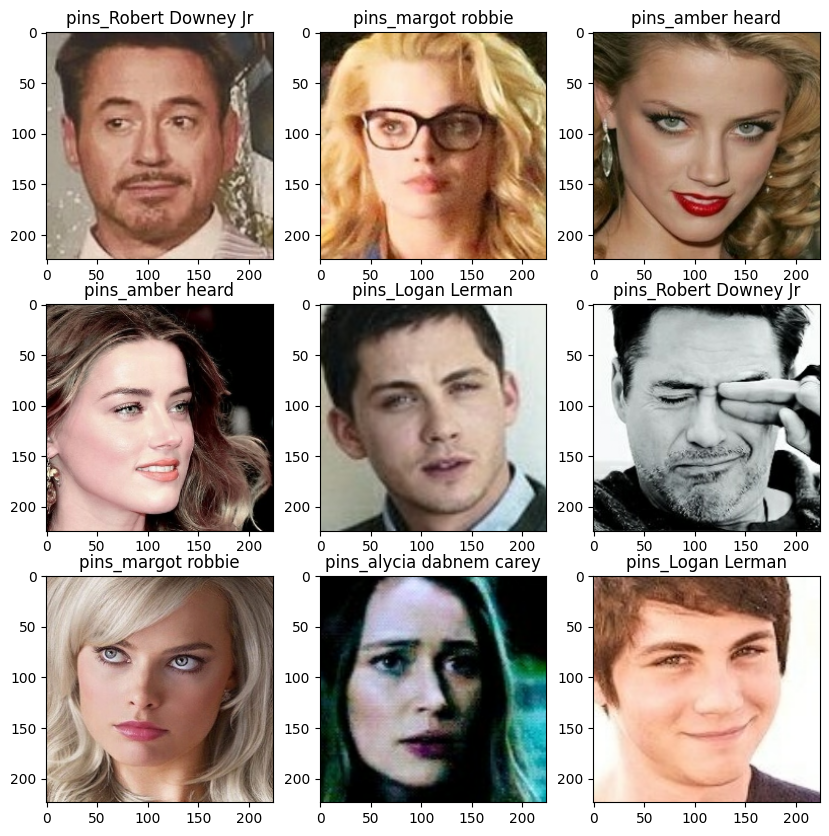

In [213]:
def visualize_batch(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(index_to_label[labels[i].numpy()])
            plt.axis("on")

visualize_batch(train_dataset)

# Implement ResNet from Scratch:


In [214]:
def conv_batchnorm_relu(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [215]:
def identity_block(tensor, filters):
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
    x = BatchNormalization()(x)
    x = Add()([tensor,x]) # skip connection
    x = ReLU()(x)
    return x

In [216]:
def projection_block(tensor, filters, strides):

     #left stream
     x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=strides)
     x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
     x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
     x = BatchNormalization()(x)

     #right stream
     shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)
     shortcut = BatchNormalization()(shortcut)
     x = Add()([shortcut,x])    #skip connection
     x = ReLU()(x)
     return x


In [217]:
def resnet_block(x, filters, reps, strides):

    x = projection_block(x, filters, strides)
    for _ in range(reps-1):
        x = identity_block(x,filters)
    return x

In [218]:
# Compile Model with Learning Rate Scheduler
learning_rate = 0.001


In [219]:
# Callbacks for Early Stopping and LR Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


- ## ResNet-50


In [220]:
input = Input(shape=input_shape)

NUMBER_OF_CLASSES = len(label_to_index)
x = conv_batchnorm_relu(input, filters=64, kernel_size=7, strides=2)
x = MaxPooling2D(pool_size = 3, strides =2)(x)
x = resnet_block(x, filters=64, reps =3, strides=1)
x = resnet_block(x, filters=128, reps =4, strides=2)
x = resnet_block(x, filters=256, reps =6, strides=2)
x = resnet_block(x, filters=512, reps =3, strides=2)
x = GlobalAvgPool2D()(x)


output = Dense(NUMBER_OF_CLASSES, activation ='softmax')(x)


res50_model = Model(inputs=input, outputs=output)

In [221]:
res50_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_118[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_98 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 55, 55,    │          0 │ re_lu_98[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 55, 55,    │      4,160 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_119[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_99 (ReLU)     │ (None, 55, 55,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 55, 55,    │     36,928 │ re_lu_99[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        256 │ conv2d_120[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_100 (ReLU)    │ (None, 55, 55,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 55, 55,    │     16,640 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 55, 55,    │     16,640 │ re_lu_100[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_122[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │      1,024 │ conv2d_121[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_68 (Add)        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_101 (ReLU)    │ (None, 55, 55,    │          0 │ add_68[0][0]    

 Total params: 23,612,300 (90.07 MB)

 Trainable params: 23,559,180 (89.87 MB)

 Non-trainable params: 53,120 (207.50 KB)

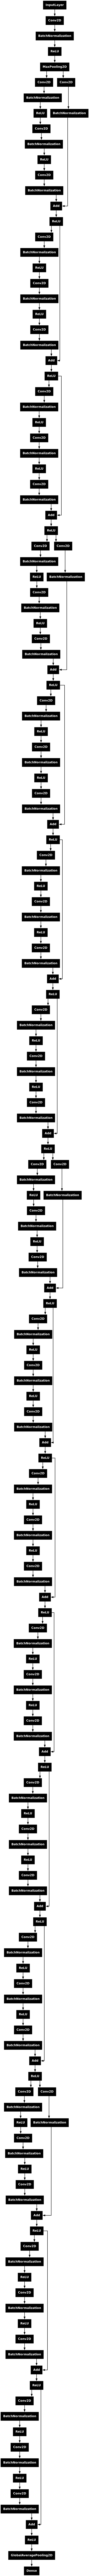

In [222]:
plot_model(res50_model)

In [223]:
res50_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [224]:
res50_history = res50_model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30


I0000 00:00:1734530417.342530      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_28', 20 bytes spill stores, 20 bytes spill loads



53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 691ms/step - accuracy: 0.1413 - loss: 3.8423 - val_accuracy: 0.0782 - val_loss: 2.7088 - learning_rate: 0.0010
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.2269 - loss: 2.4259 - val_accuracy: 0.1185 - val_loss: 2.6845 - learning_rate: 0.0010
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - accuracy: 0.2712 - loss: 2.1697 - val_accuracy: 0.0948 - val_loss: 2.9610 - learning_rate: 0.0010
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.3344 - loss: 2.0163 - val_accuracy: 0.1659 - val_loss: 2.5592 - learning_rate: 0.0010
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step - accuracy: 0.3302 - loss: 2.0011 - val_accuracy: 0.1706 - val_loss: 2.4213 - learning_rate: 0.0010
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.4257 - loss: 1.7876 - val_accuracy: 0.1635 - val_loss: 2.5442 - learning_rate: 0.0010
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.4578 - loss: 1.6443 - val_

In [225]:
res50_test_loss, res50_test_acc = res50_model.evaluate(test_dataset)
print(f"Test Accuracy: {res50_test_acc:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.5630 - loss: 1.7454
Test Accuracy: 0.5644


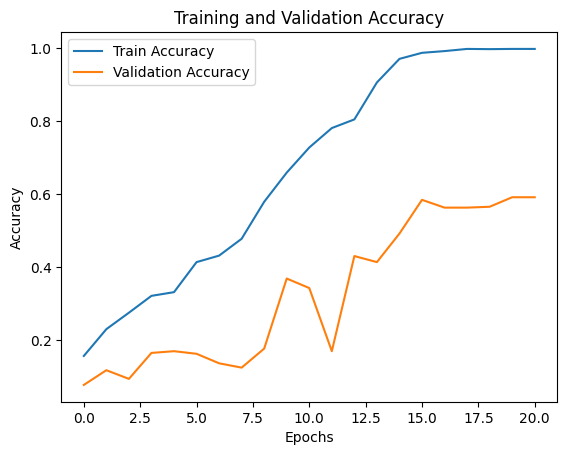

In [226]:
# Plot training and validation accuracy
plt.plot(res50_history.history['accuracy'], label='Train Accuracy')
plt.plot(res50_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

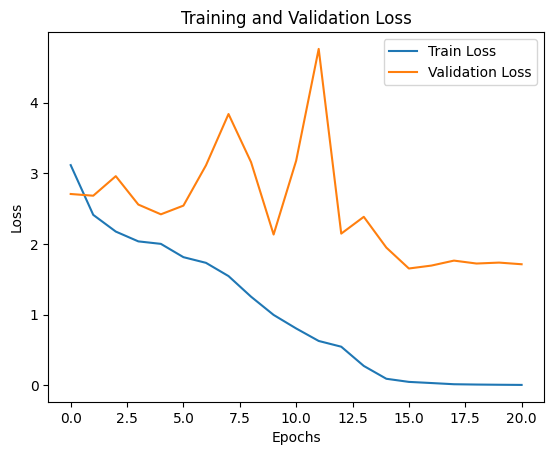

In [227]:
# Plot training and validation loss
plt.plot(res50_history.history['loss'], label='Train Loss')
plt.plot(res50_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step


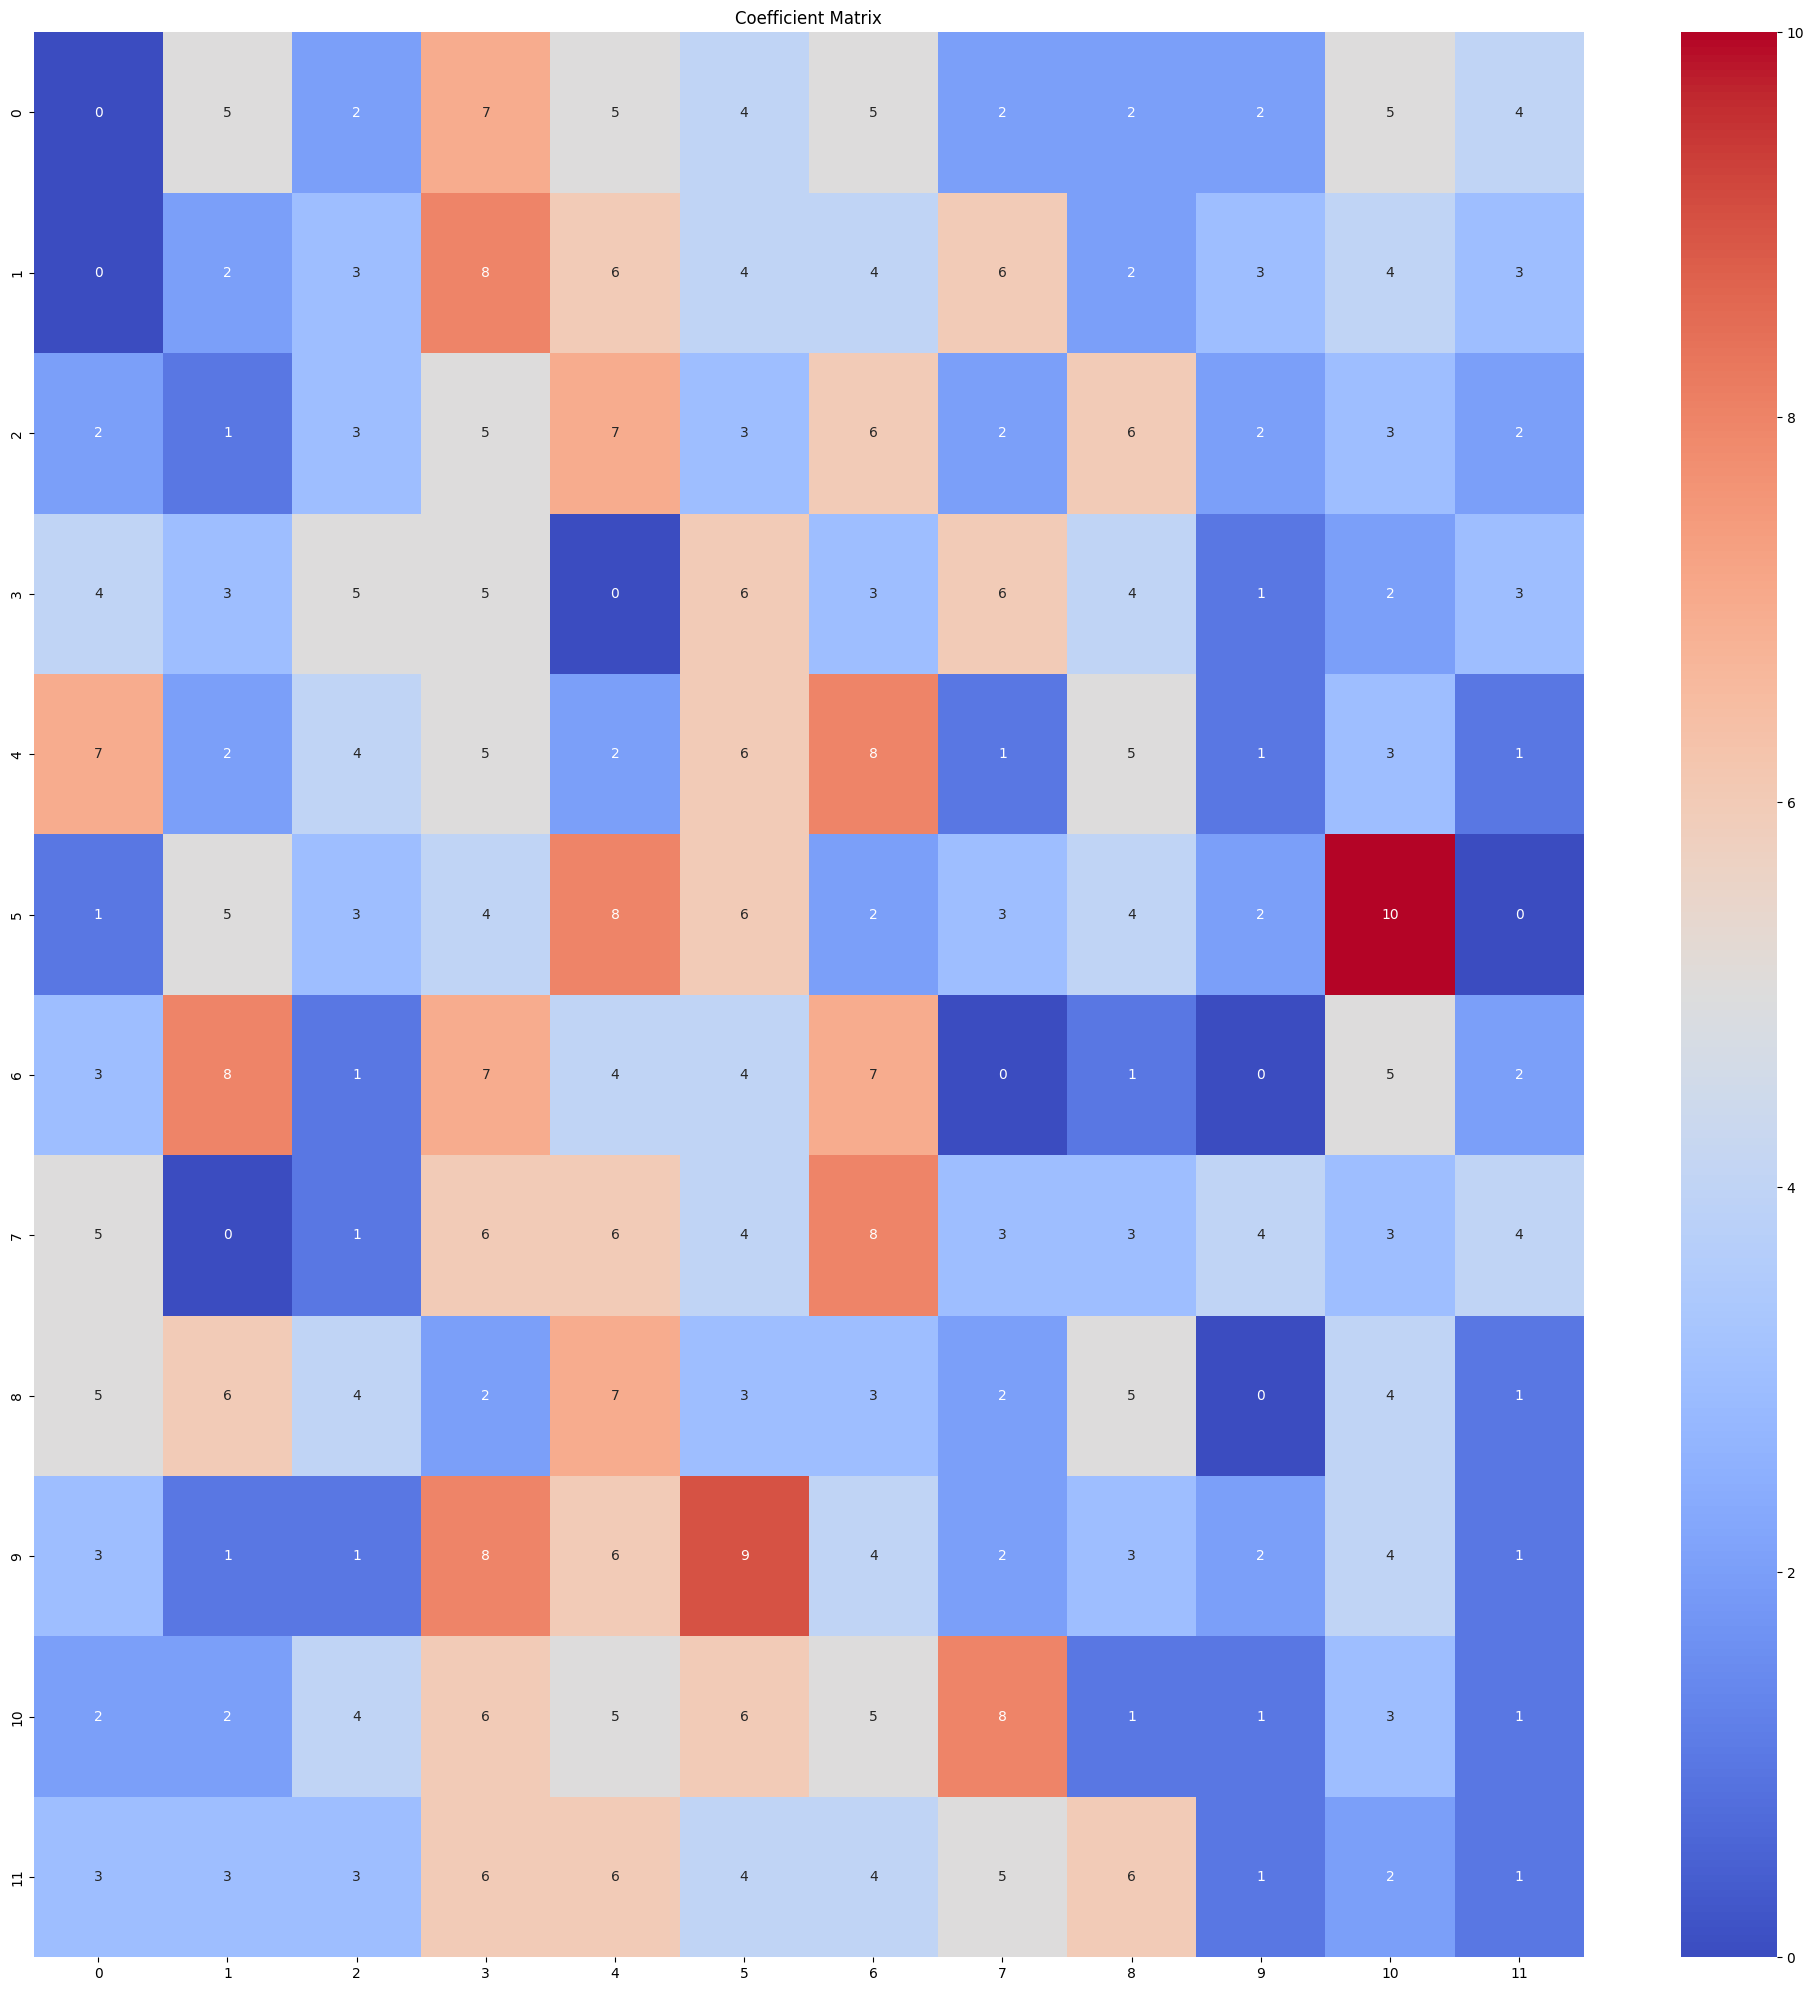

In [228]:
y_predict = np.argmax(res50_model.predict(test_dataset), axis=-1)

# A confusion matrix 
cm_NN = confusion_matrix(test_labels_encoded, y_predict)
NN_accuracy = accuracy_score(test_labels_encoded, y_predict)

NN_accuracy, cm_NN


# Plot the heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(cm_NN, annot=True, cmap='coolwarm', fmt='g', cbar=True, )

plt.title('Coefficient Matrix')
plt.show()

### Precision, Recall, F-Score


### ROC-AUC


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


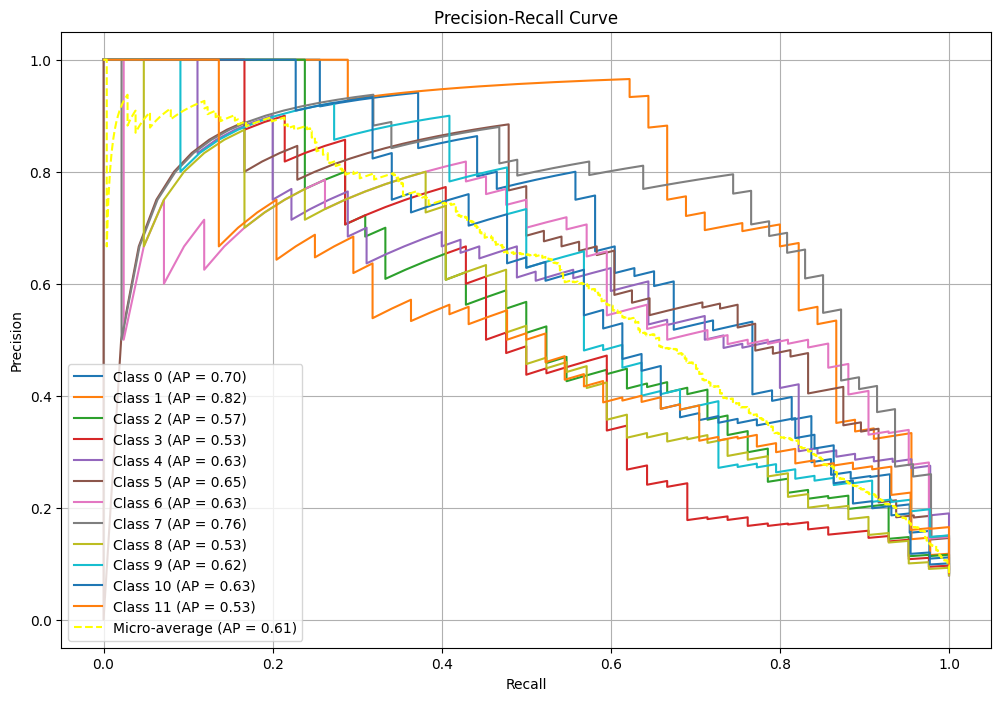

Classification Report:
              precision    recall  f1-score   support

           0     0.6857    0.5581    0.6154        43
           1     0.7895    0.6667    0.7229        45
           2     0.5588    0.4524    0.5000        42
           3     0.3623    0.5952    0.4505        42
           4     0.5161    0.7111    0.5981        45
           5     0.5254    0.6458    0.5794        48
           6     0.5085    0.7143    0.5941        42
           7     0.7750    0.6596    0.7126        47
           8     0.4762    0.4762    0.4762        42
           9     0.8947    0.3864    0.5397        44
          10     0.5208    0.5682    0.5435        44
          11     0.6087    0.3182    0.4179        44

    accuracy                         0.5644       528
   macro avg     0.6018    0.5627    0.5625       528
weighted avg     0.6042    0.5644    0.5646       528



In [229]:
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists for true labels and predicted probabilities
y_true = []
y_pred_proba = []

# Collect y_true and y_pred_proba
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # True labels
    predictions = res50_model.predict(images)  # Get predicted probabilities
    y_pred_proba.extend(predictions)  # Append probabilities

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Binarize the true labels
classes = np.arange(y_pred_proba.shape[1])  # Total number of classes
y_true_bin = label_binarize(y_true, classes=classes)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(12, 8))  # Adjust the figure size

for i in range(y_pred_proba.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {avg_precision:.2f})')

# Micro-average Precision-Recall curve
precision_micro, recall_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_proba.ravel())
avg_precision_micro = average_precision_score(y_true_bin, y_pred_proba, average='micro')

plt.plot(recall_micro, precision_micro, label=f'Micro-average (AP = {avg_precision_micro:.2f})', color='yellow', linestyle='--')

# Final plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

# Get predicted classes
y_pred = np.argmax(y_pred_proba, axis=-1)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

In [230]:
from keras.utils import to_categorical

# One-Hot Encode True Labels for Multi-Class ROC-AUC
num_classes = y_pred_proba.shape[1]
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)



In [231]:
# ROC-AUC and Precision-Recall Curve for Each Class
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

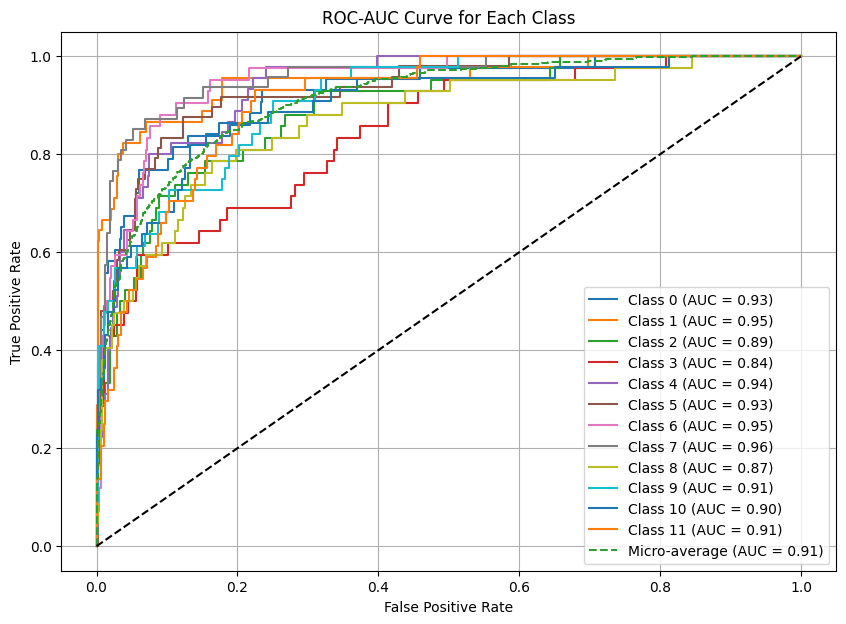

In [232]:
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Each Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Using Xception for Transfer Learning


In [233]:
# Load the pre-trained Xception model without the top layer (classification)
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

In [234]:
# Freeze the layers of the base model
base_model_xception.trainable = False

In [235]:
# Add custom top layers for your dataset
x = GlobalAveragePooling2D()(base_model_xception.output)
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(NUMBER_OF_CLASSES, activation='softmax', 
               kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

In [236]:
# Create the final model
model_xception = Model(inputs=base_model_xception.input, outputs=output)

In [237]:
model_xception.compile(
    optimizer=Adam(learning_rate=learning_rate), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [238]:
# Print the model summary
model_xception.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_9[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_171 (Conv2D) │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_171[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_84 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_84[0][0]    

 Total params: 20,886,068 (79.67 MB)

 Trainable params: 24,588 (96.05 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

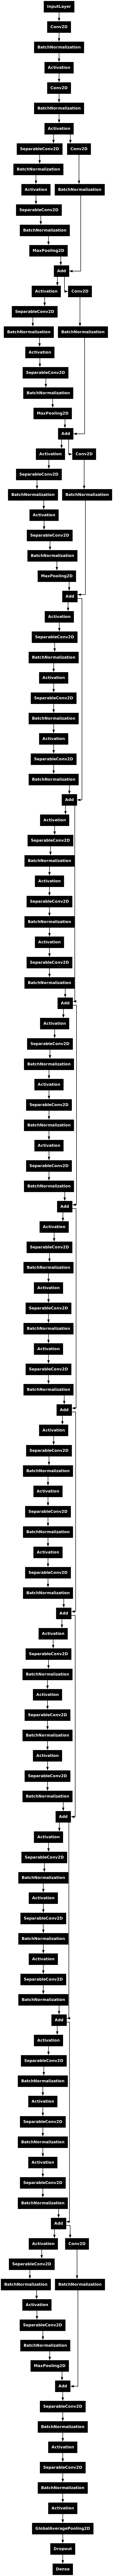

In [239]:
plot_model(model_xception)

In [262]:
history_xception = model_xception.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=40,
    batch_size=32,
    #callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.6019 - loss: 1.5394 - val_accuracy: 0.5071 - val_loss: 1.7504
Epoch 2/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.6023 - loss: 1.5268 - val_accuracy: 0.5166 - val_loss: 1.7470
Epoch 3/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.6220 - loss: 1.5008 - val_accuracy: 0.5024 - val_loss: 1.7618
Epoch 4/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.5843 - loss: 1.5748 - val_accuracy: 0.5000 - val_loss: 1.7534
Epoch 5/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.5850 - loss: 1.5384 - val_accuracy: 0.5071 - val_loss: 1.7559
Epoch 6/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.6104 - loss: 1.5339 - val_accuracy: 0.5071 - val_loss: 1.7577
Epoch 7/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.5827 - loss: 1.5694 - val_accuracy: 0.5142 - val_loss: 1.7601
Epoch 8/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.6024 - loss: 1.5385 - val_accu

In [263]:
test_loss, test_acc = model_xception.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.4770 - loss: 1.8226
Test Accuracy: 0.5038


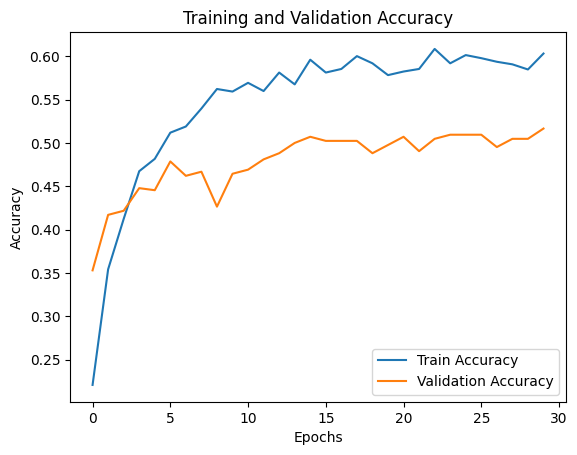

In [242]:
# Plot training and validation accuracy
plt.plot(history_xception.history['accuracy'], label='Train Accuracy')
plt.plot(history_xception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

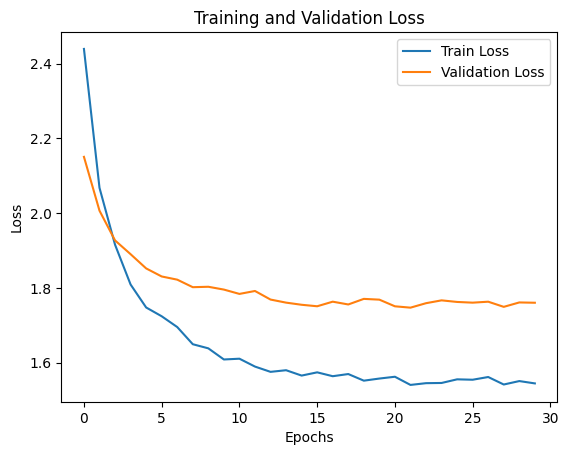

In [243]:
# Plot training and validation loss
plt.plot(history_xception.history['loss'], label='Train Loss')
plt.plot(history_xception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step


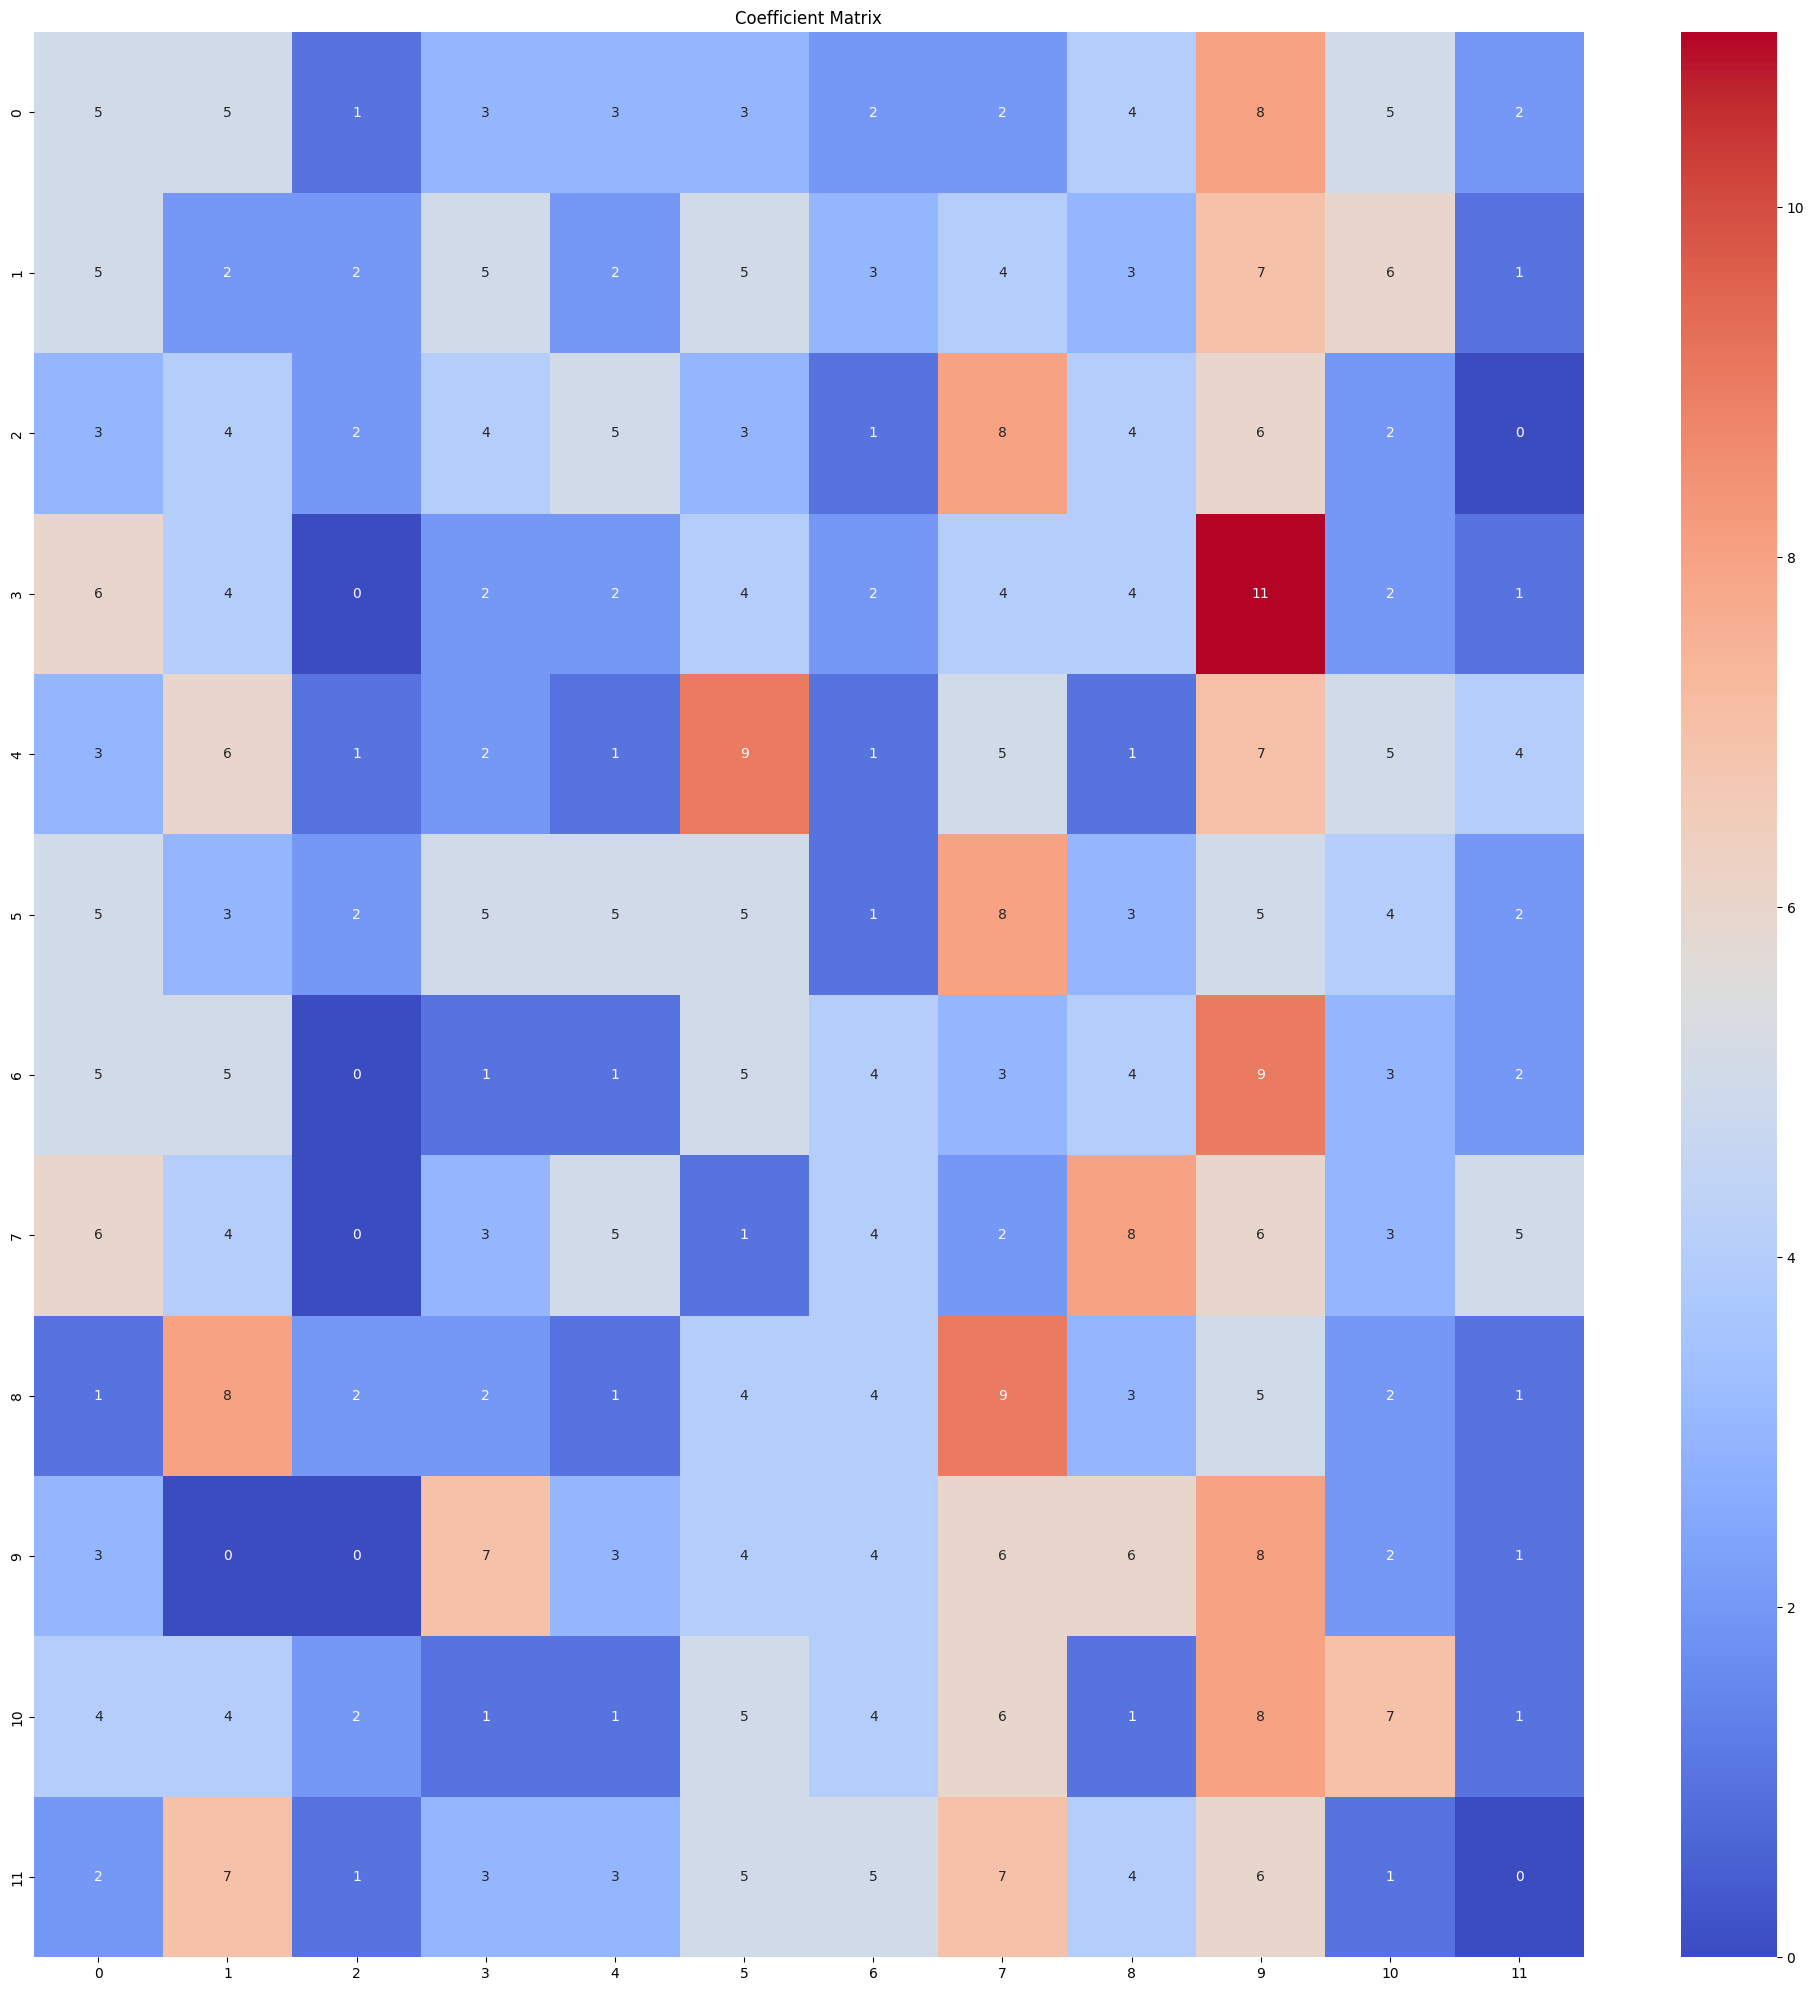

In [244]:
y_predict = np.argmax(model_xception.predict(test_dataset), axis=-1)

# A confusion matrix 
cm_NN = confusion_matrix(test_labels_encoded, y_predict)
NN_accuracy = accuracy_score(test_labels_encoded, y_predict)

NN_accuracy, cm_NN


# Plot the heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(cm_NN, annot=True, cmap='coolwarm', fmt='g', cbar=True, )

plt.title('Coefficient Matrix')
plt.show()

### Precision, Recall, F-Score


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


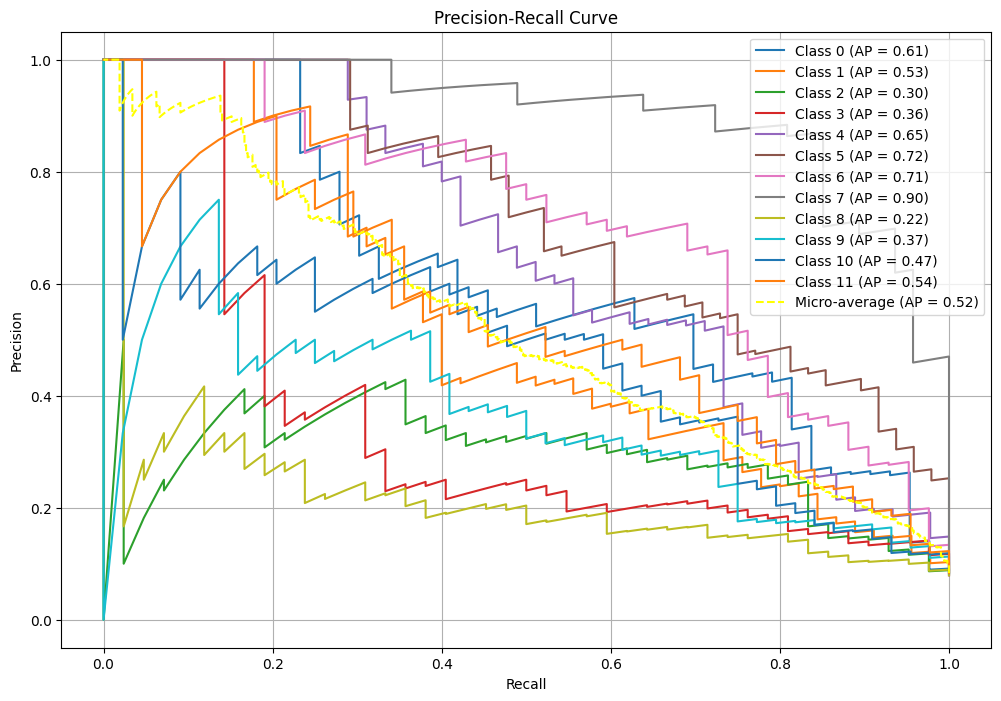

Classification Report:
              precision    recall  f1-score   support

           0     0.5417    0.6047    0.5714        43
           1     0.3462    0.4000    0.3711        45
           2     0.3846    0.1190    0.1818        42
           3     0.2632    0.2381    0.2500        42
           4     0.6562    0.4667    0.5455        45
           5     0.6415    0.7083    0.6733        48
           6     0.6857    0.5714    0.6234        42
           7     0.6875    0.9362    0.7928        47
           8     0.3111    0.3333    0.3218        42
           9     0.3023    0.5909    0.4000        44
          10     0.5238    0.5000    0.5116        44
          11     0.5000    0.2273    0.3125        44

    accuracy                         0.4811       528
   macro avg     0.4870    0.4747    0.4629       528
weighted avg     0.4904    0.4811    0.4680       528



In [245]:
# Initialize lists for true labels and predicted probabilities
y_true = []
y_pred_proba = []

# Collect y_true and y_pred_proba
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # True labels
    predictions = model_xception.predict(images)  # Get predicted probabilities
    y_pred_proba.extend(predictions)  # Append probabilities

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Binarize the true labels
classes = np.arange(y_pred_proba.shape[1])  # Total number of classes
y_true_bin = label_binarize(y_true, classes=classes)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(12, 8))  # Adjust the figure size

for i in range(y_pred_proba.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {avg_precision:.2f})')

# Micro-average Precision-Recall curve
precision_micro, recall_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_proba.ravel())
avg_precision_micro = average_precision_score(y_true_bin, y_pred_proba, average='micro')

plt.plot(recall_micro, precision_micro, label=f'Micro-average (AP = {avg_precision_micro:.2f})', color='yellow', linestyle='--')

# Final plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

# Get predicted classes
y_pred = np.argmax(y_pred_proba, axis=-1)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

### ROC-AUC


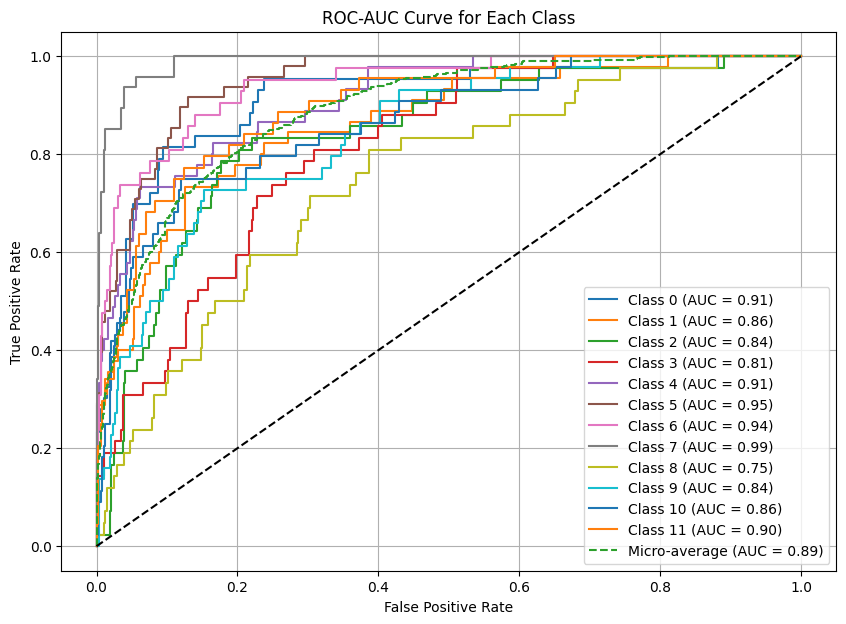

In [246]:
from keras.utils import to_categorical

# One-Hot Encode True Labels for Multi-Class ROC-AUC
num_classes = y_pred_proba.shape[1]
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)

# ROC-AUC and Precision-Recall Curve for Each Class
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Each Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Using DenseNet for Transfer Learning


In [247]:
# Load the pre-trained DenseNet model without the top layer (classification)
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)


In [248]:
# Freeze the layers of the base model
base_model_densenet.trainable = False


In [249]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

In [250]:
# Add custom top layers for your dataset
x = GlobalAveragePooling2D()(base_model_densenet.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Dropout to regularize
output = Dense(NUMBER_OF_CLASSES, activation='softmax')(x)

In [251]:
# Create the final model
model_densenet = Model(inputs=base_model_densenet.input, outputs=output)


In [252]:
# Compile the model
model_densenet.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [253]:
# Print the model summary
model_densenet.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,053,900 (26.91 MB)

 Trainable params: 14,348 (56.05 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

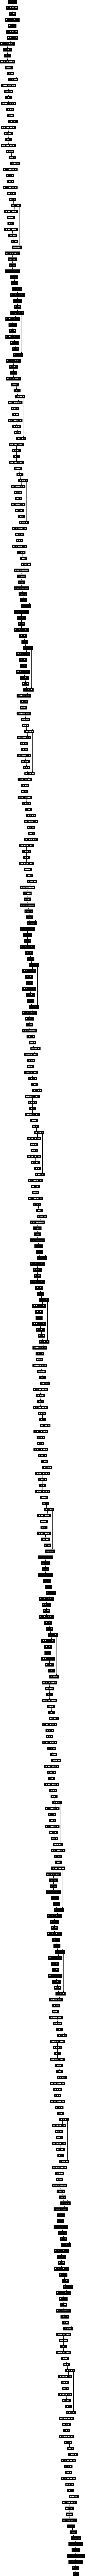

In [254]:
plot_model(model_densenet)

In [255]:
# Train the model on your dataset
history_densenet = model_densenet.fit(
    train_dataset,
    validation_data=val_dataset, 
    epochs=30, 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 419ms/step - accuracy: 0.1372 - loss: 2.9958 - val_accuracy: 0.2488 - val_loss: 2.1391 - learning_rate: 0.0010
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.3384 - loss: 2.0641 - val_accuracy: 0.3934 - val_loss: 1.8737 - learning_rate: 0.0010
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.4164 - loss: 1.7701 - val_accuracy: 0.4573 - val_loss: 1.6904 - learning_rate: 0.0010
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.4788 - loss: 1.5054 - val_accuracy: 0.5213 - val_loss: 1.5646 - learning_rate: 0.0010
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.5194 - loss: 1.4345 - val_accuracy: 0.5545 - val_loss: 1.4898 - learning_rate: 0.0010
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.6021 - loss: 1.2577 - val_accuracy: 0.5853 - val_loss: 1.4027 - learning_rate: 0.0010
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.5895 - loss: 1.2184 -

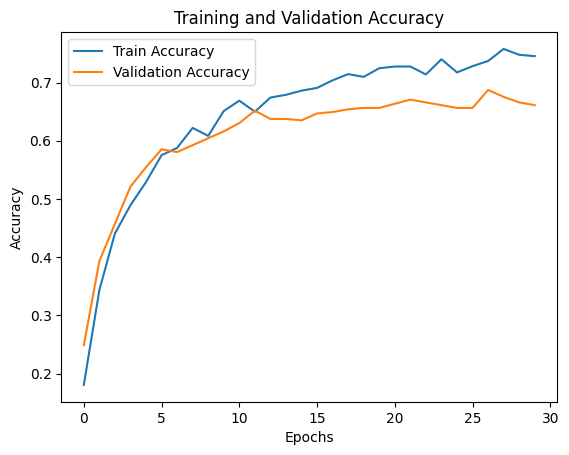

In [256]:
# Plot training and validation accuracy
plt.plot(history_densenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

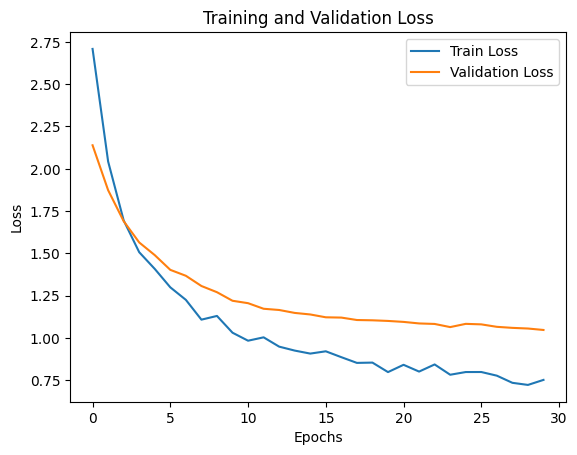

In [257]:
# Plot training and validation loss
plt.plot(history_densenet.history['loss'], label='Train Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 470ms/step


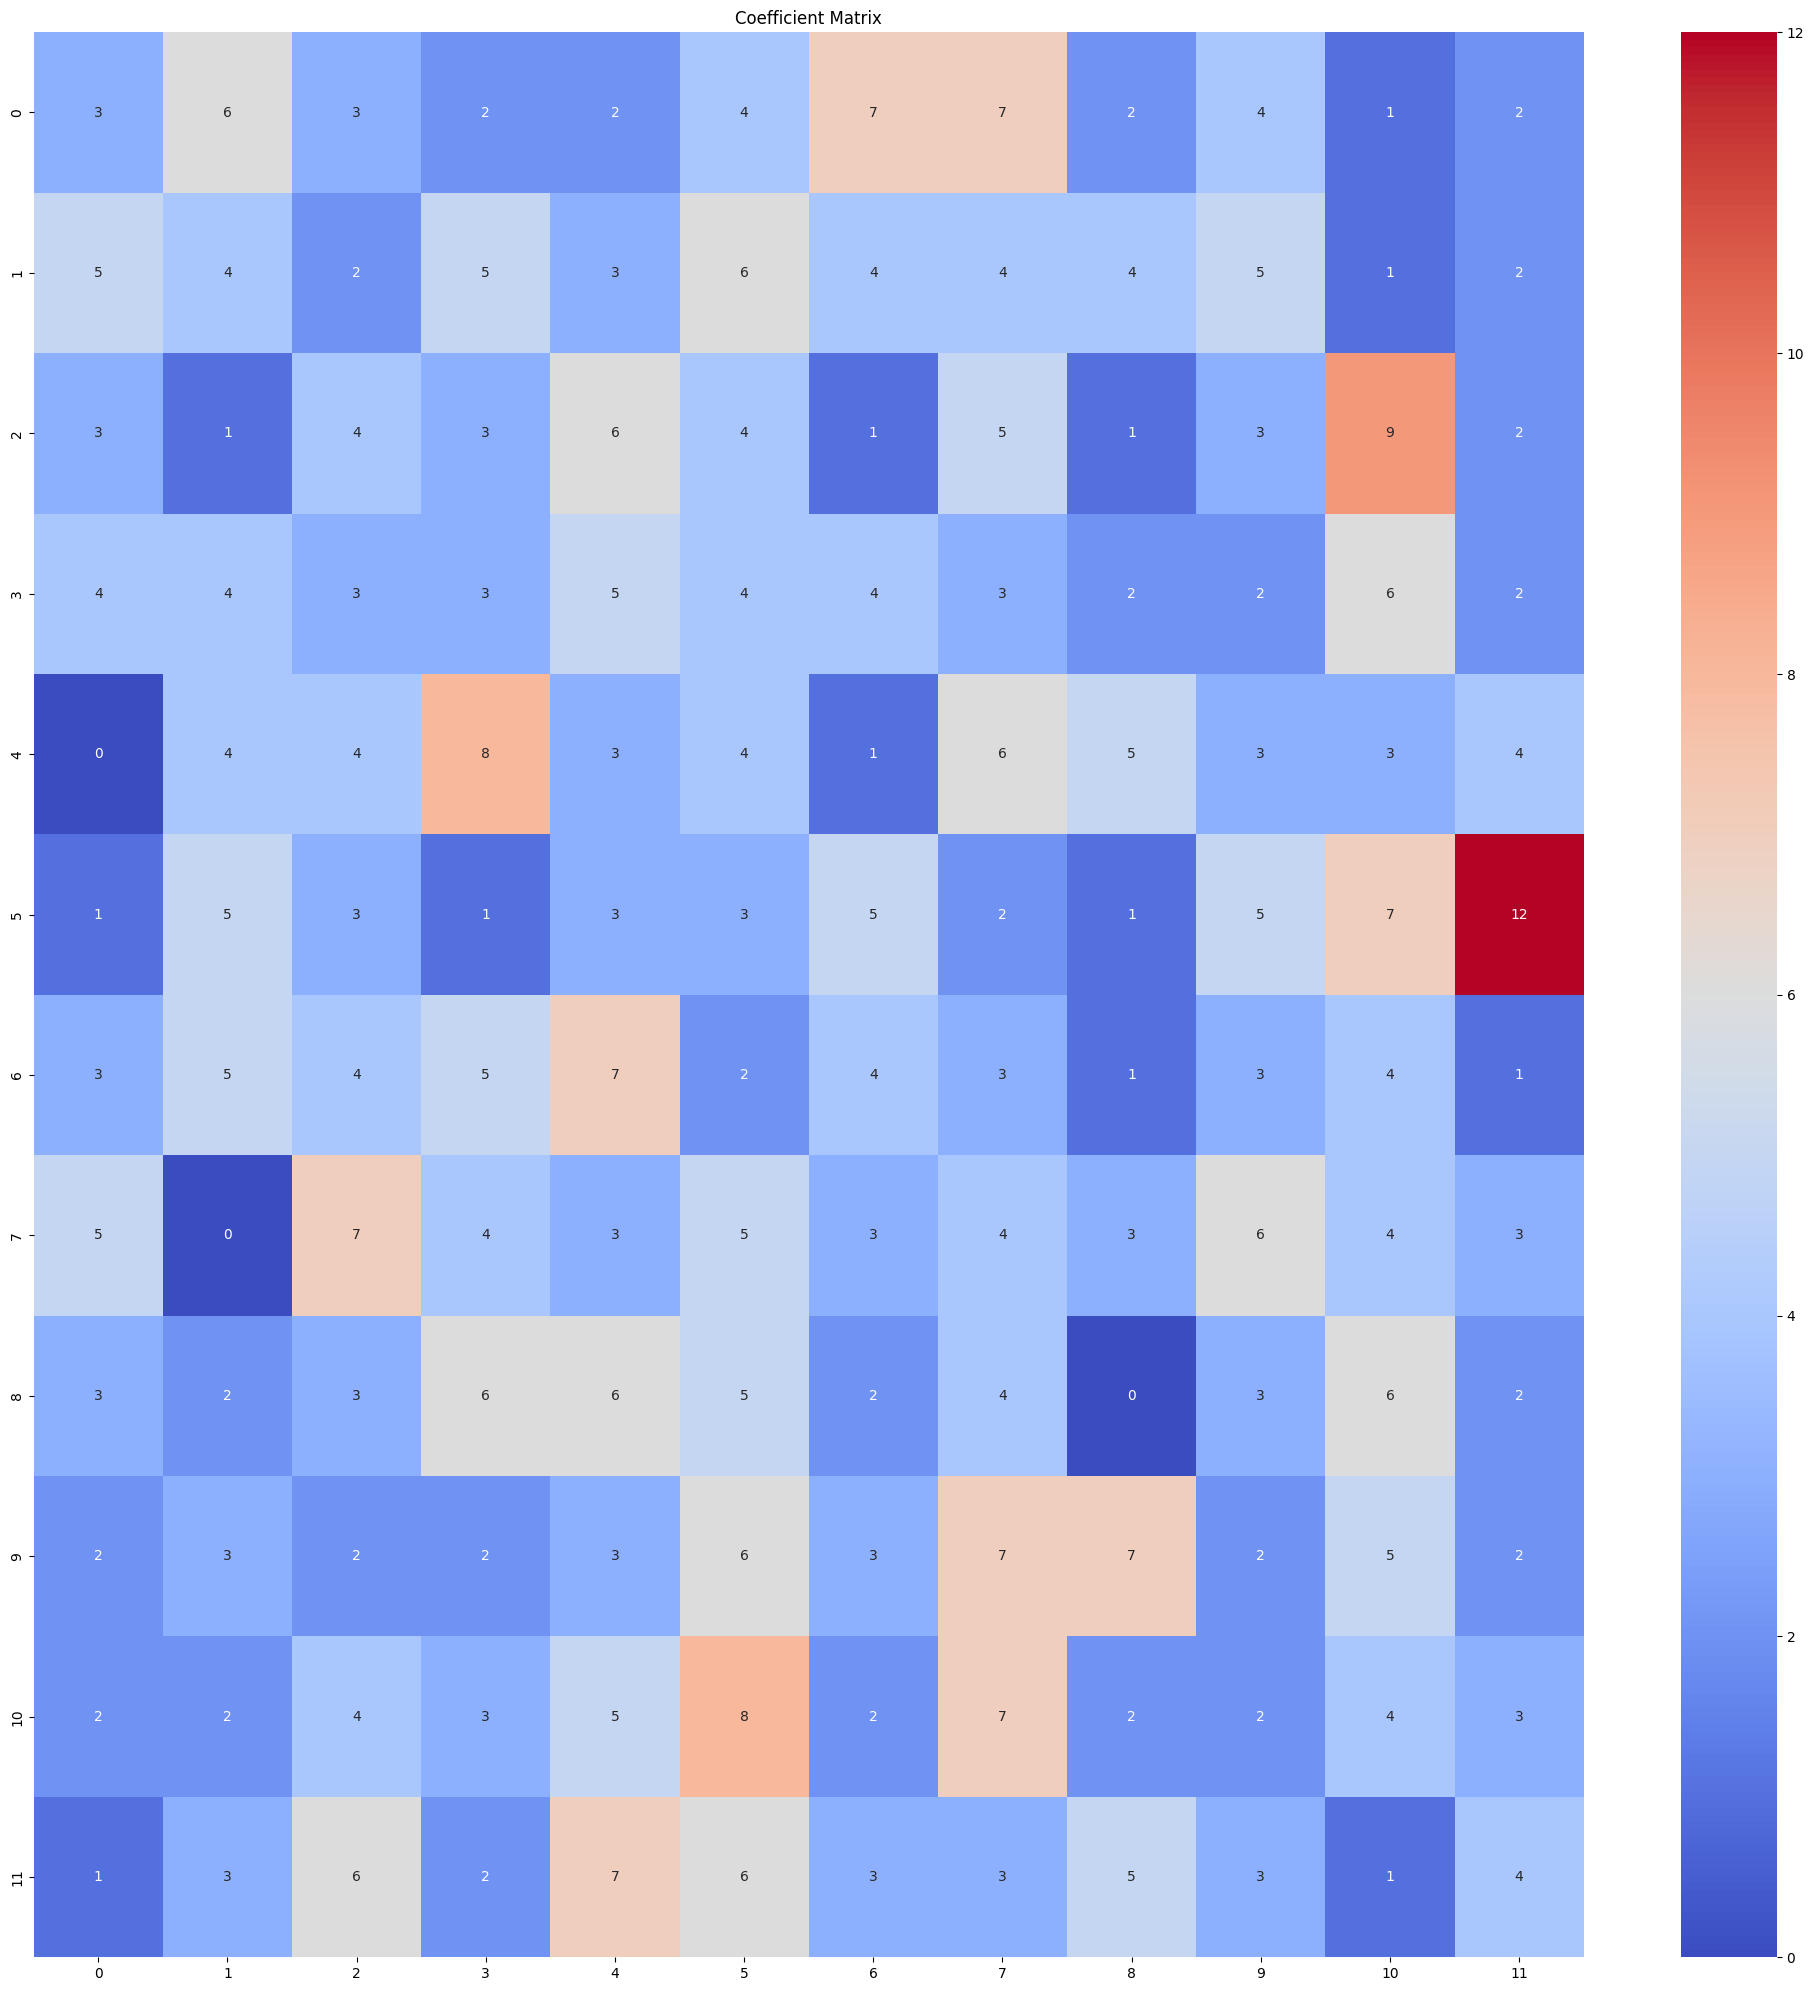

In [258]:
y_predict = np.argmax(model_densenet.predict(test_dataset), axis=-1)

# A confusion matrix 
cm_NN = confusion_matrix(test_labels_encoded, y_predict)
NN_accuracy = accuracy_score(test_labels_encoded, y_predict)

NN_accuracy, cm_NN


# Plot the heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(cm_NN, annot=True, cmap='coolwarm', fmt='g', cbar=True, )

plt.title('Coefficient Matrix')
plt.show()

### Precision, Recall, F-Score


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


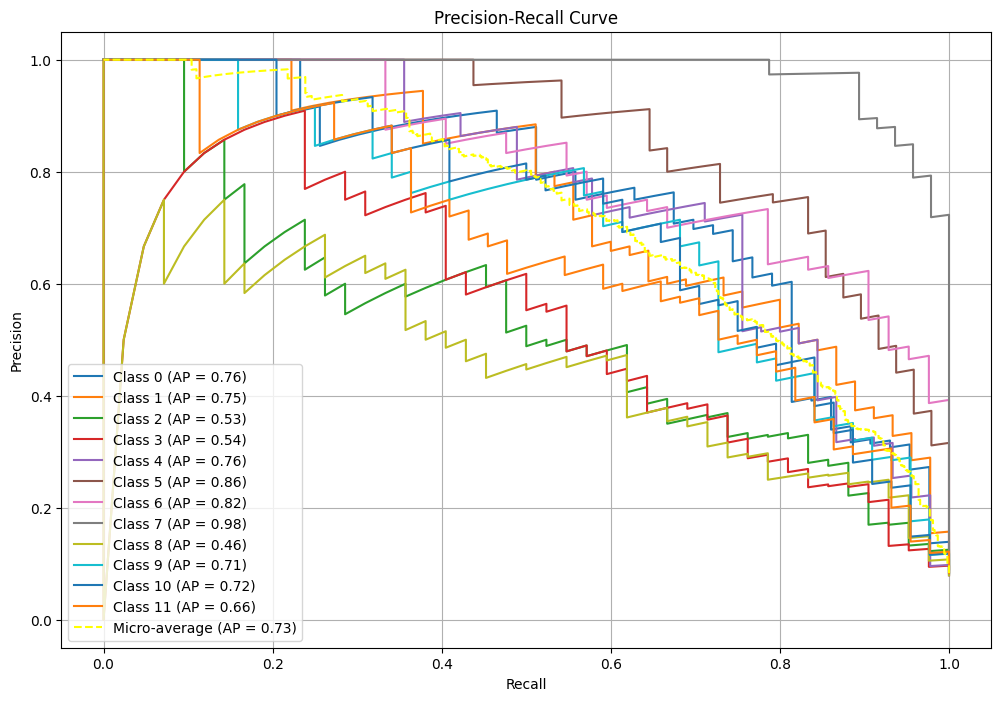

Classification Report:
              precision    recall  f1-score   support

           0     0.7812    0.5814    0.6667        43
           1     0.6923    0.6000    0.6429        45
           2     0.4889    0.5238    0.5057        42
           3     0.4773    0.5000    0.4884        42
           4     0.6415    0.7556    0.6939        45
           5     0.7018    0.8333    0.7619        48
           6     0.7179    0.6667    0.6914        42
           7     0.8182    0.9574    0.8824        47
           8     0.5152    0.4048    0.4533        42
           9     0.6829    0.6364    0.6588        44
          10     0.5882    0.6818    0.6316        44
          11     0.6154    0.5455    0.5783        44

    accuracy                         0.6458       528
   macro avg     0.6434    0.6406    0.6379       528
weighted avg     0.6461    0.6458    0.6419       528



In [259]:
# Initialize lists for true labels and predicted probabilities
y_true = []
y_pred_proba = []

# Collect y_true and y_pred_proba
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # True labels
    predictions = model_densenet.predict(images)  # Get predicted probabilities
    y_pred_proba.extend(predictions)  # Append probabilities

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)

# Binarize the true labels
classes = np.arange(y_pred_proba.shape[1])  # Total number of classes
y_true_bin = label_binarize(y_true, classes=classes)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(12, 8))  # Adjust the figure size

for i in range(y_pred_proba.shape[1]):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {avg_precision:.2f})')

# Micro-average Precision-Recall curve
precision_micro, recall_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_pred_proba.ravel())
avg_precision_micro = average_precision_score(y_true_bin, y_pred_proba, average='micro')

plt.plot(recall_micro, precision_micro, label=f'Micro-average (AP = {avg_precision_micro:.2f})', color='yellow', linestyle='--')

# Final plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

# Get predicted classes
y_pred = np.argmax(y_pred_proba, axis=-1)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))


### ROC-AUC


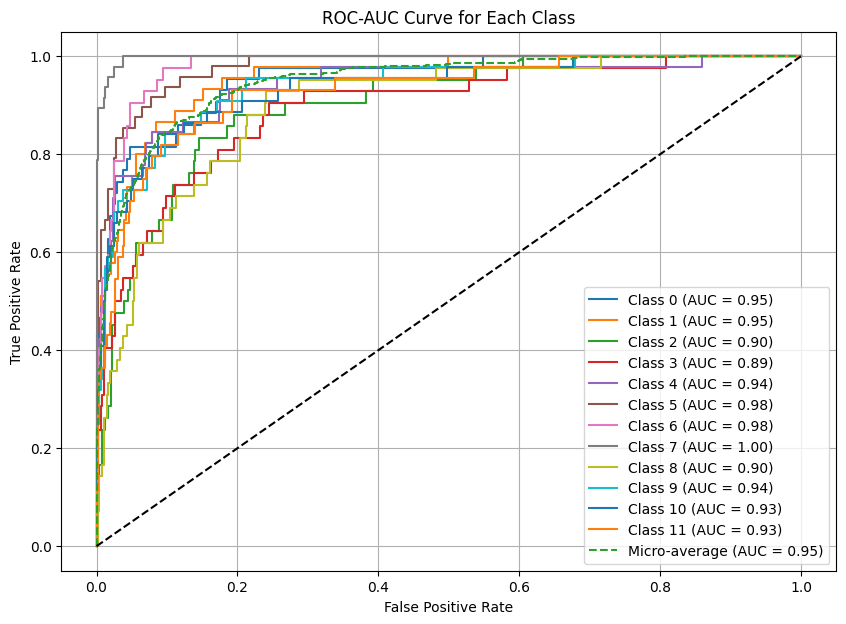

In [260]:
# One-Hot Encode True Labels for Multi-Class ROC-AUC
num_classes = y_pred_proba.shape[1]
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)

# ROC-AUC and Precision-Recall Curve for Each Class
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Each Class')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Summary


In [264]:
# ResNet

res50_test_loss, res50_test_acc = res50_model.evaluate(test_dataset)
print(f"ResNet50 Test Accuracy: {100*res50_test_acc:.4f}")

# Xception
test_loss_xception, test_acc_xception = model_xception.evaluate(test_dataset)
print(f"Xception Test Accuracy: {100*test_acc_xception:.4f}")

# DenseNet
test_loss_densenet, test_acc_densenet = model_densenet.evaluate(test_dataset)
print(f"DenseNet Test Accuracy: {100*test_acc_densenet:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.5515 - loss: 1.8215
ResNet50 Test Accuracy: 56.4394
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.5155 - loss: 1.7359
Xception Test Accuracy: 50.3788
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6404 - loss: 1.0842
DenseNet Test Accuracy: 64.5833
